Michael Stafford, Tyler Sanders, Andrew Cherpeski, Alex Melo, and Samuel McIntyre

# **Introduction**

While the success of a high school is typically measured by graduation rates and standardized test scores, the reality of a typical student’s education may be influenced by a multitude of factors including economic factors, class sizes, teacher pay, and more. Our project examines two separate metrics for school success: the average ACT score and the graduation rate for a given school. We investigated what factors are most highly associated with school success in order to suggest future causality research about those highly correlated factors. Ultimately, we hope schools will be able to use these data in order to better serve the educational needs of their students.

Several studies have explored this field. Walden University delved into the impact of class size on student success, yielding inconclusive results [1]. East Tennessee State University conducted research on the correlation between per-pupil expenditure, ACT scores, and graduation rates, concluding that graduation rates increased while ACT composite scores remained unaffected [2]. In 2022, the Canadian National Library of Medicine published a study on the various psychological, physical, and environmental factors that predict student performance in the long run [3]. In contrast, due to the limitation of our data, our research focus was solely at a school-level analysis with the hope of finding factors to predict average school performance.

Our primary source of data was the Utah State Board of Education (USBE) [4], which publishes yearly district- and school-level data. In particular, we used the datasets that track ACT scores, graduation rates, median class sizes, and enrollment demographic data. Our data focus on the 2021 and 2022 school years, as this is the most recent ACT score data available. We used exclusively school-level data for our project and focused only on schools with 11th- and 12th-grade students.

Our paper is structured as follows: we detail our data cleaning procedure, use a logistic regression to model graduation rate data, use standard OLS, Lasso, and Ridge regressions, then summarize our findings. We chose to use these models because our study focuses on regression problems rather than classification problems. Additionally, we note that while ACT data is technically bounded (between 1 and 36), we considered linear regression appropriate because our dataset falls mostly within the middle third of the 1-36 range and there is considerable variance in our data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings; warnings.simplefilter('ignore')

# **Data Cleaning and Feature Engineering**
	
   Our data were drawn from many different datasets from the USBE that we merged together. First, we cleaned each of them individually. Missing values were addressed by replacing them with the average in that column. Non-numeric data that we intended to use in regression were one-hot encoded (such as whether a school belongs to a district or is a charter school). We eliminated irrelevant variables that did not relate to our research question. This included district names, most information about years other than 2022, and schools that do not have information on 11th and 12th graders. Once each of these individual datasets were cleaned, we stitched them together using Stata, merging on the name of the school (which is uniquely identified by an encoding in the data). Stata lends itself naturally to this task since it provides an excellent interface for merging and visualizing data. Merging all datasets together substantially reduces the sample size, from about 200 schools with ACT data to around 130 with all relevant data. Further datasets and features could be included, but at the cost of unreasonably reducing our sample size. This was the case for the median class size dataset. Fortunately, it appears to be the case that the schools most likely to be in only some of the datasets are smaller, and therefore less relevant to the analysis once we weight by school size.
   
   We also performed extensive feature engineering with Stata. For instance, we replaced several variables that tracked the number of students in a school with a given race or characteristic with percentages, so that they would be comparable across schools. We created one-hot encodings for a number of variables, and we also created new variables by summing over other ones to provide additional options for independent variables to be used in regression. An example of this was to create a variable measuring the percentage of a school that was a racial minority, created by adding up all of the students who were not white. Finally, we renamed variables to have cleaner and more intuitive names for ease of use. A brief example of cleaning one of the raw datasets is given below, an interested reader can see the supplementary .do file for the data merging.


In [2]:
#Read in data
attendance_22 = pd.read_excel('Data/2022Attendance.xlsx',sheet_name='By School')
school_names = pd.read_excel("Data/School Names and ID.xlsx")
attendance_22 = attendance_22[attendance_22['Measure'] == 'Attendance Rate']
#rename columns, drop irrelevant columns
attendance_22 = attendance_22.rename(columns={'School_Name':'School Name','school_id':'School ID'})
attendance_22 = attendance_22.drop(columns=['LEA Type','Measure', 'School Year', 'LEA_name', 'district_id', 'district_nbr','school_number'])
col_names = attendance_22.columns
col_names = [col_names[0]] + [col_names[-1]] + list(col_names[1:-1])
attendance_22 = attendance_22[col_names]
#rename Utah Arts Academy OLD to Utah Arts Academy in the 2022 data
attendance_22.loc[attendance_22['School Name']=='Utah Arts Academy OLD','School Name'] = 'Utah Arts Academy'
attendance_22_short = attendance_22.copy()
attendance_22_short.drop(attendance_22_short.filter(regex='Grade [1-8]$').columns, axis=1,inplace=True)
attendance_22_short.drop(columns=['Kindergarten'],inplace=True)
attendance_22_short.dropna(subset=['Grade 12'],inplace=True)
#Fill any missing attendance data with the "overall" attendance data
for col in attendance_22_short.columns[7:]:
    attendance_22_short[col] = attendance_22_short[col].fillna(attendance_22_short['K-12 Overall'])
#Rename columns
attendance_22_short.rename(columns={'K-12 Overall':'Overall'},inplace=True)
columns_rename = dict()
for col in attendance_22_short.columns[2:]:
    columns_rename[col] = f'{col} Attendance 2022'
attendance_22_short.rename(columns=columns_rename,inplace=True)
#Add a AVG minority attendance column:
minorities = list(attendance_22_short.columns[7:])
minorities.remove('White Attendance 2022');
minorities.remove('Female Attendance 2022');minorities.remove('Male Attendance 2022')
attendance_22_short['Avg Minority Attendance 2022'] = attendance_22_short[minorities].sum(axis=1)/len(minorities)

# **Analysis**

## Graduation Rates

We begin by using graduation rates as the target variable. Graduation rates are expressed as a percentage, so each $y_i \in [0,1]$. As such, a logistic regression would be more appropriate to model the data. To do this, we split our target data around the average high school graduation rate in Utah, which is 0.882 [5]. Therefore, our target variable is the indicator function 
$\tilde{y_i} = \chi_{[0.882,1]}$.

Any $\tilde{y_i} = 1$ corresponds to a high school with an above-average graduation rate, while a $\tilde{y_i} = 0$ corresponds to a below-average graduation rate. We use the following features for our model: mean school administrator salary, administrator to teacher mean salary, an indicator for whether the school is a charter school, the attendance rates for all students, the male attendance rate, the attendance rate of minority students, the attendance rate of economically disadvantaged students, and the logarithm of the total number of students in the school. Our model was weighted by student population to avoid smaller schools being over-represented. Additionally, we regularized our model. Our results are as follows:

In [3]:
X = pd.read_csv("cleaned_with_salaries.csv") #Additional data cleaning
X = X[['admin_sal', 'admin_to_teacher', 'students_11_12', 'gradrate', 'charter', 'attendance22','male', 'minority', 'disadvantaged', 'log_students']]
X = X.dropna() # Some attendance values are null. These will be dropped
y_rate = X['gradrate'].copy()
UTAH_GRAD_RATE = .882 # Define average graduation rates
y = y_rate > UTAH_GRAD_RATE
del X['gradrate'] # Remove the graduation rate column from X
# Define the sample weights based on the number of students, remove population col, do regression
weights = X['students_11_12'] / X['students_11_12'].sum()
del X['students_11_12']
log_reg = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=False, weights=weights)
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               gradrate   No. Observations:                  129
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            8
Date:                Thu, 14 Dec 2023   Pseudo R-squ.:                  0.2201
Time:                        14:46:04   Log-Likelihood:                -68.855
converged:                       True   LL-Null:                       -88.293
Covariance Type:            nonrobust   LLR p-value:                 5.186e-06
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -20.6020      7.238     -2.846      0.004     -34.788      -6.416
admin_sal        -7.007e-06   1.31e-05     -0.537      0.591   -3.26e-05    1.86e-05
admin_to_teacher    -0.5816      0.558     -1.042      0.297      -1.675       0.512
charter             -0.9840      0.637     -1.545      0.122      -2.232       0.264
attendance22        25.8759      7.589      3.410      0.001      11.002      40.750
male                -2.4351      3.727     -0.653      0.514      -9.741       4.871
minority            -1.2526      1.310     -0.956      0.339      -3.820       1.315
disadvantaged       -1.0507      1.260     -0.834      0.404      -3.521       1.419
log_students         0.1684      0.220      0.765      0.444      -0.263       0.600
====================================================================================
"""

The above table summarizes our findings. The only variables considered to be statistically significant are the intercept and the attendance variable. All other variables have a p-value of at least 0.1. Male attendance, minority attendance, and economically disadvantaged attendance are negatively correlated with graduation rates, but these coefficients are statistically insignificant. More research would be needed to determine whether these variables are truly negatively correlated.

It seems intuitive that attendance is strongly correlated with graduation rates. After all, students who do not graduate high school generally don't attend frequently. Additionally, in Utah (and most other states), high school graduation requirements are such that simply attending goes a long way in helping a student graduate.

To further analyze the correlation between attendance and graduation rates, we ran a simple logistic regression with attendance as the only feature. A graph is included below: 

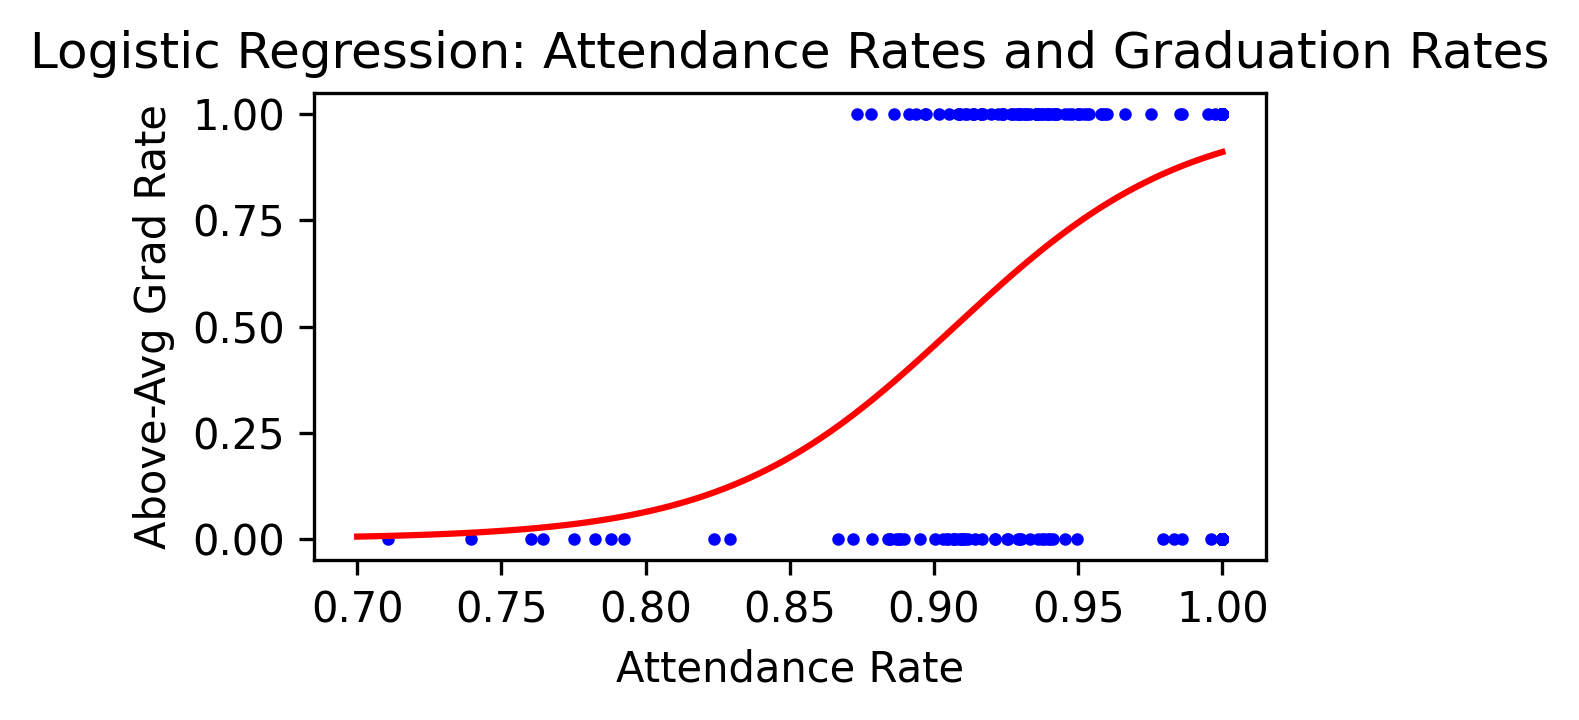

In [4]:
plt.figure(figsize=(4,2.5),dpi=300)
attendance = X[['attendance22']]
attendance = sm.add_constant(attendance)
attend_model = sm.Logit(y, attendance).fit_regularized(disp=False, weights=weights) #Run the model only on attendance
plt.plot(attendance, y, 'bo', markersize=2) #Plot attendance data
domain = np.linspace(0.7,1,100)
beta = attend_model.params.values
model = np.vectorize(lambda x: (1 + np.exp(-1*(beta[0] + x*beta[1])))**-1)
plt.plot(domain, model(domain), 'r-') #Plot the results
plt.title("Logistic Regression: Attendance Rates and Graduation Rates")
plt.xlabel("Attendance Rate"); plt.ylabel("Above-Avg Grad Rate"); 
plt.tight_layout(); plt.show()

Again, there is a clear positive correlation between the attendance rate and whether a high school has an above-average graduation rate. We concluded that the graduation rate is not a strong indicator of student success due to a lack of standardization. Different high schools and districts have different graduation requirements, so one high school's graduation rate does not always relate well to that of another high school.

## ACT Scores
Since the ACT is a standardized test, we treated ACT scores as the dependent variable corresponding to a more accurate metric for school success. We performed a regression treating the 2021 ACT data as an independent variable and the 2022 data as a dependent variable and found that the coefficient value was 0.89 even with no other control variables (besides a constant). If we weight by the number of juniors and seniors at the school then the coefficient increases to 0.999 - so the schools with the most consistent scores are the larger ones, which is what we would expect. This means that the prior year's average ACT score is an excellent predictor of how a school will perform this year. Because of this, we concluded that average ACT scores are mostly independent of what specific students are taking the test, and highly dependent on the school the students go to. Furthermore, we concluded that using the 2022 ACT data alone as the dependent variable was a valid measure of school success. Visual representations below show that the spread of ACT scores in the sample is significant and somewhat bell shaped, as well as the persistence of ACT scores from year to year. 

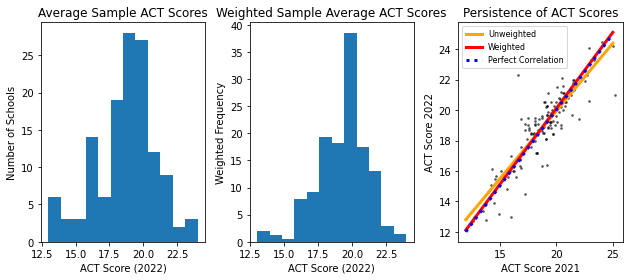

In [19]:
data = pd.read_csv('cleaned_with_salaries.csv') #Make a histogram of ACT scores,Weight by School Size
weights = data['students_11_12'] / data['students_11_12'].mean()
act22 = np.round(data['act22'])
fig, [ax, ax2, ax3] = plt.subplots(figsize=(9,4), nrows=1, ncols=3)
act22.plot(kind='hist', bins=12, grid=False, ax=ax)
act22.plot(kind="hist", weights=weights, ax = ax2, bins=12)
ax.set_title("Average Sample ACT Scores"); ax.set_xlabel("ACT Score (2022)"); ax.set_ylabel("Number of Schools")
ax2.set_title("Weighted Sample Average ACT Scores"); 
ax2.set_xlabel("ACT Score (2022)"); ax2.set_ylabel("Weighted Frequency"); plt.tight_layout()
X = data['act21'].values.reshape(-1,1) #Regression of past year ACT on this year ACT
y = data['act22'].values.reshape(-1,1)
act_reg_model = LinearRegression().fit(X, y) #Unweighted Model
beta, intercept = act_reg_model.coef_, act_reg_model.intercept_
act_reg_model.fit(X, y, weights) #Weighted Model
beta2, intercept2 = act_reg_model.coef_, act_reg_model.intercept_
domain = np.linspace(12, 25, 100)
ax3.scatter(data['act21'], data['act22'], color='black', marker='o', alpha=0.5, s=3) #Persistence Graph
ax3.plot(domain, intercept[0]+beta[0]*domain, lw=3, label='Unweighted', color='orange')
ax3.plot(domain, intercept2[0]+beta2[0]*domain, lw=3, label='Weighted', color='red')
ax3.plot(domain, domain, ':', lw=3, label='Perfect Correlation', color='blue')
ax3.set_xlabel("ACT Score 2021"); ax3.set_ylabel("ACT Score 2022"); 
ax3.set_title("Persistence of ACT Scores"); ax3.legend(fontsize=8); plt.show()

### Standard OLS
In all models we weighted by the student population in order to prioritize larger schools since they had more students that took the test. Moreover, they are of greater interest since they represent the majority of students. This also helps to produce more reasonable results, since the smallest schools tend to have unusually high or low ACT scores since many of them are more specialized in nature. Our first pass at the data involved using OLS and manually evaluating which features seemed to be important as well as how predictive our data were. The results are below.

In [26]:
y = data['act22'].values #Regression with many different features
X = data[['admin_sal','admin_to_teacher', 'teacher_sal', 'log_students', 'attendance21','attendance22', 'american_indian','black', 'asian', 'hispanic', 'multiple_race', 'pacific_islander', 'totalk12', 'grade9', 'grade10', 'grade11', 'grade12', 'female','disadvantaged', 'english_learner', 'disability','homeless', 'charter']]
X = sm.add_constant(X.fillna(0))
model = sm.OLS(y, X).fit(weights=weights)
print("MSE:", round(mean_squared_error(model.predict(X), y),3), "AIC:", round(model.aic,3), "BIC:", round(model.bic,3), "R2", round(model.rsquared,3))

MSE: 1.359 AIC: 463.063 BIC: 532.25 R2 0.77


The above regression suggests that many of the variables we have are not very relevant in predicting a school's average ACT score. Although none of the columns are strictly collinear, including all of these variables does introduce a number of columns that are nearly multicollinear (such as attendance in 2021 and 2022), which undoubtedly overfits the model and produces bad estimates for beta. The following variables seem as if they are not aiding in our predictions: teacher salaries, log number of students, detailed breakdown of school size, percent female (Based on p values, not shown, but available by uncommenting print model summary). If we remove those variables we get the model in the next panel. 

In [27]:
y = data['act22'].values #Regression with further reduced data
X = data[['american_indian', 'black', 'asian', 'hispanic', 'multiple_race', 'pacific_islander','totalk12', 'disadvantaged', 'english_learner', 'disability','homeless', 'charter']]
X = sm.add_constant(X.fillna(0))
model = sm.OLS(y, X).fit(weights=weights)
print("MSE:", round(mean_squared_error(model.predict(X), y),3), "AIC:", round(model.aic,3), "BIC:", round(model.bic,3), "R2", round(model.rsquared,3))

MSE: 1.547 AIC: 458.171 BIC: 495.647 R2 0.739


This model has nearly the same $R^2$ value as the previous one, and improved AIC and BIC scores. Almost all of the features appear to be statistically significant, with the exception of pacificislander proportion, total number of students, and possibly proportion economically disadvantaged. Essentially what this indicates is that, given the available data, predictions made just on the racial proportions of a school seem to predict the average ACT score perform just as well as regressions that include more features. To test that, we include a regression using only the racial breakdown in the next panel. 

In [23]:
y = data['act22'].values #Regression with exclusively Racial Breakdown
X = data[['american_indian','black', 'asian', 'hispanic', 'multiple_race', 'pacific_islander']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
print("MSE:", round(mean_squared_error(model.predict(X), y),3), "AIC:", round(model.aic,3), "BIC:", round(model.bic,3), "R2", round(model.rsquared,3))

MSE: 3.09 AIC: 537.508 BIC: 557.688 R2 0.478


However, in this model we see a sharp drop in $R^2$ and a substantial rise in AIC, BIC, and MSE, so clearly some of the other features were actually important in making predictions, and forcasting ACT scores just based on racial demographics is a mistake. In subsequent sections we will explore other approaches such as Ridge and Lasso to identify a good model for the data. 

### Lasso & Ridge Regularization
We performed Lasso regularization with a hyperparameter gridsearch in order to determine feature importance. The features that were kept mainly related to minority demographic data, but also included other features including student population and whether it was a charter school. This feature selection process highlights the power of demographic data in predicting ACT scores and reinforces our prior analysis.

In [24]:
full_dataset = pd.read_csv('cleaned_with_salaries.csv') #Read in Dataset, drop appropriate columns
full_dataset = full_dataset.fillna(0)
schoolnames = full_dataset['school']
columns = full_dataset.columns
to_drop = ['leaname','school', 'leatype','act21', 'act22', 'english21', 'english22', 'math21', 'math22', 'reading21', 'reading22', 'science21','grade9','grade10','grade11', 'grade12', 'science22', 'students_11_12','gradrate', 'cohortyear','schoolid_y','totalk12', 'female', 'white','district','minority']
X = full_dataset.drop(columns=to_drop)
y = full_dataset['act22']
reg_lasso = LassoCV(alphas=np.logspace(-4, 20, 100),max_iter=100000) #Do L1 regularization with sklearn
reg_lasso.fit(X, y,sample_weight=full_dataset['students_11_12']) #Fit the model
lasso_pred = reg_lasso.predict(X) #Best parameter values
MSE_lasso = mean_squared_error(y,lasso_pred)
R2_lasso = r2_score(y,lasso_pred)
params = reg_lasso.coef_
params[np.abs(params) <1e-2] = 0
zero_index = params==0
not_selected_features_lasso = np.array(X.columns)[zero_index]
selected_features_lasso = np.array(X.columns)[~zero_index]
selected_features_lasso_str = ', '.join(map(str, selected_features_lasso)) #Print the selected and not selected features
not_selected_features_lasso_str = ', '.join(map(str, not_selected_features_lasso))
print(f'''Selected features Lasso:\n{selected_features_lasso_str}
Unselected features Lasso:\n{not_selected_features_lasso_str}
Best MSE Lasso: {round(MSE_lasso,3)}
Best R2 Lasso: {round(R2_lasso,3)}''')

Selected features Lasso:
log_students, attendance21, attendance22, black, asian, hispanic, disadvantaged, english_learner, disability, charter
Unselected features Lasso:
admin_sal, admin_to_teacher, teacher_sal, american_indian, multiple_race, pacific_islander, male, homeless
Best MSE Lasso: 2.375
Best R2 Lasso: 0.599


In the Ridge Regression model below, we see that this model has a fairly high $R^2$ value at .71. It also has a lower MSE than the Lasso, indicating that this model has some predictive advantages over the R1 regularization term.

In [25]:
full_dataset = pd.read_csv('cleaned_with_salaries.csv') #Read in Dataset, drop appropriate columns
full_dataset = full_dataset.dropna(axis=0)
schoolnames = full_dataset['school']
columns = full_dataset.columns
to_drop = ['leaname','school', 'leatype','act21', 'act22', 'english21', 'english22', 'math21', 'math22', 'reading21', 'reading22', 'science21','grade9','grade10','grade11', 'grade12', 'science22', 'students_11_12', 'gradrate', 'cohortyear', 'schoolid_y', 'totalk12', 'female', 'white','district','minority']
X = full_dataset.drop(columns=to_drop)
y = full_dataset['act22']
reg_ridge = RidgeCV(alphas=np.logspace(-4, 3, 15)) #Do L1 regularization with sklearn
reg_ridge.fit(X, y,sample_weight=full_dataset['students_11_12']) # Fit the model
ridge_pred = reg_ridge.predict(X) #Best parameter values
MSE_ridge = mean_squared_error(y,ridge_pred)
R2_ridge = r2_score(y,ridge_pred)
params = reg_ridge.coef_
zero_index = params==0
print(f"Best MSE Ridge: {round(MSE_ridge,3)}")
print(f"Best R2 Ridge: {round(R2_ridge,3)}")

Best MSE Ridge: 1.668
Best R2 Ridge: 0.712


# Conclusion and Ethics
Our dataset was fairly limited. We only analyzed Utah high schools, but a future analysis would include similar data at a national level. Furthermore, more specific county level data from the US census could be used to address some of the complexities of demographic data. Despite limited data, we successfully identified an area of future research for exploring success factors for Utah’s schools. Our analysis does not imply a causal relationship between our explanatory and target variables, but it can be a starting point for further analysis designed to uncover a causal effect.

Race is typically heavily correlated with income and other factors that are correlated with educational outcomes, and probably serves as a proxy for these data that were not included in our dataset. Research suggests that quality K-12 education is a proven pathway out of generational poverty, especially for minority students [6]. Unfortunately, the ERIC finds that those minority students that benefit so much from a quality education are typically underserved with fewer educational resources leading to worse educational outcomes [7]. Our analysis suggests that schools’ average ACT performance is strikingly associated with the underlying demographics of the student body. Because of this, we suggest that further investigation be done into what causes these inequities. We repeat the age-old caution that correlation does not imply causation. This association is not cause to try to exclude or otherwise discriminate against underserved demographics. Demographics are complex and multifaceted, and using strict proportions of demographics does not reflect the nuanced reality of culture, language, mobility, family structure, economic status, and other pertinent reasons for this inequity. This correlation may be rooted in a multitude of factors. For example, the ERIC also investigated differences of help-seeking behavior among different demographics and advocates for students to take control and responsibility for their choices in the learning environment [8]. Closing the gaps of racial inequity is a formidable problem, and our analysis serves to say that it is still a clear and present problem that needs to be addressed in Utah's schools. Nevertheless, addressing these disparities is clearly essential in helping schools successfully serve the diverse needs of their students.

Furthermore, comparison between the metrics of graduation rates and ACT scores reveals that ACT scores serve as a better way to measure a school’s success. The heavy incentivization of graduation rates seems to often serve to the detriment of students. Instead of helping students to graduate, graduation standards have instead been lowered to the point of being almost entirely predicted by simple attendence. School should serve the diverse needs of their students, and unfortunately the proxy goal of high graduation seems to not serve very well to helping schools accomplish their true goal. This perhaps suggests a reevaluation of graduation standards throughout the state as well as their use as a proxy goal for schools. It also speaks to the efficacy the ACT and other standardized testing for evaluation of schools.

In short, although quality K-12 education demonstrably helps minority students escape poverty, systemic inequities in educational outcomes among different demographics exist throughout Utah's schools. This topic requires further investigation as well as a shift from solely prioritizing graduation rates to more nuanced metrics like ACT scores in evaluating educational outcomes.

# References
[1] Todd, C. (2008). The effect of class size on student success (Order No. 3303970). Available from ProQuest Dissertations & Theses Global. (304389683). Retrieved from https://www.proquest.com/docview/304389683?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses

[2] Irvin, J. A. (2017). Per pupil expenditure, graduation rates, and ACT scores in tennessee school districts (Order No. 10757682). Available from ProQuest Dissertations & Theses Global. (2015907972). Retrieved from https://www.proquest.com/docview/2015907972?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses

[3] Dubuc MM, Aubertin-Leheudre M, Karelis AD. Predictors of Academic Performance in High School Students: The Longitudinal ASAP Study. Int J Exerc Sci. 2022 May 1;15(4):616-631. PMID: 35992498; PMCID: PMC9365103.

[4] Utah State Board of Education. Reports. Retrieved from URL: https://www.schools.utah.gov/ data/reports?mid=1424&tid=0

[5] Institute of Education Sciences: The Influence of School Demographics on the Relationship Between Students’ Help-Seeking Behavior and Performance and Motivational Measures https://files.eric.ed.gov/fulltext/ED599236.pdf

[6] Utah State Board of Education. Graduation Rates Reports. Retrieved from https://www.schools.utah.gov

[7] Institute of Education Sciences: Supporting Students Living in Poverty https://files.eric.ed.gov/fulltext/EJ1230335.pdf

[8] Boyd JK, Kuuleialoha Kamaka SA, Braun KL. Pathway out of poverty: a values-based college-community partnership to improve long-term outcomes of underrepresented students. Prog Community Health Partnersh. 2012 Spring;6(1):25-31. doi: 10.1353/cpr.2012.0006. PMID: 22643785; PMCID: PMC4697265.